In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

C:\Users\quocv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create a data loader for the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

Files already downloaded and verified


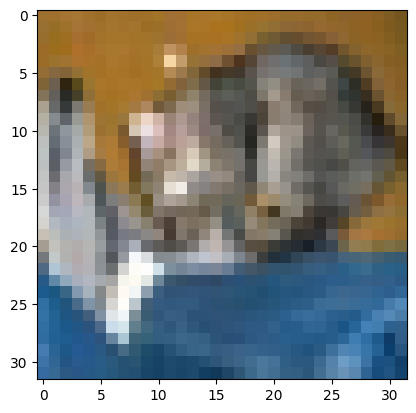

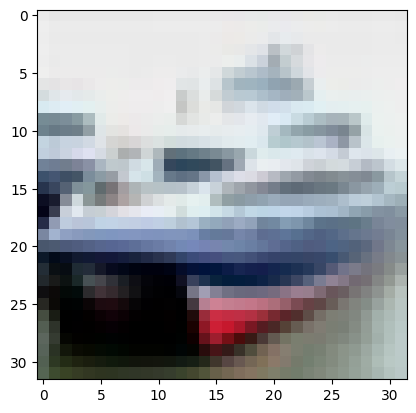

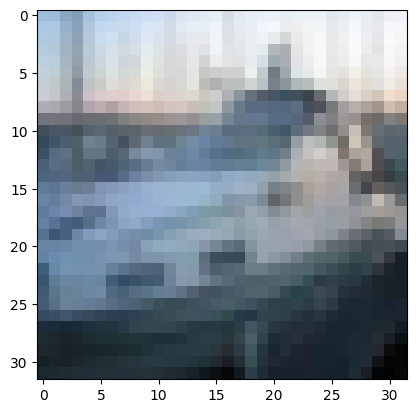

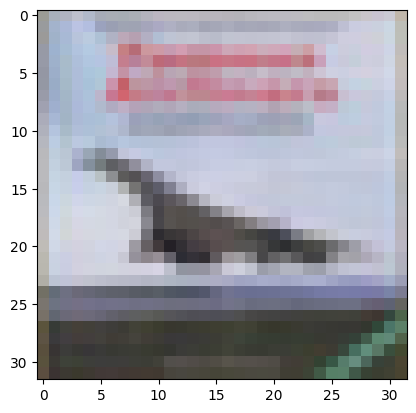

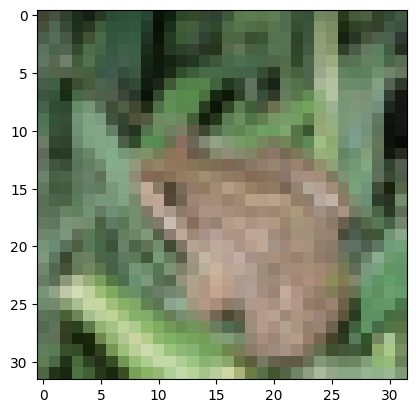

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa các phép biến đổi cho dữ liệu
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải tập dữ liệu testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

# Hàm hiển thị hình ảnh
def imshow(img):
    img = img / 2 + 0.5  # Giải nén giá trị ảnh
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Lấy 5 ảnh đầu tiên từ tập dữ liệu testing
dataiter = iter(testloader)
images, labels = next(dataiter)

# Hiển thị 5 ảnh đầu tiên
for i in range(5):
    imshow(images[i])


+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


# 1. Improved MLP Model
class ImprovedMLP(nn.Module):
    def __init__(self, n_features, n_hidden1=512, n_hidden2=256, n_classes=10):
        super(ImprovedMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_features, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Add dropout for regularization

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout again
        x = self.fc3(x)
        return x

# 2. Model Initialization
def getModel(n_features):
    model = ImprovedMLP(n_features)
    return model

# 3. Data Loading and Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),  # Add data augmentation
    transforms.RandomCrop(32, padding=4) # Add data augmentation
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,  # Increased batch size
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=64,  # Increased batch size
                                         shuffle=False, num_workers=2)

# 4. Model, Loss, and Optimizer
n_features = 32 * 32 * 3
model = getModel(n_features)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer

# 5. Training Loop
n_epochs = 20  # Increased number of epochs

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")

# 6. Evaluation
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # Corrected line
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
[1, 200] loss: 1.936
[1, 400] loss: 1.836
[1, 600] loss: 1.794
[2, 200] loss: 1.744
[2, 400] loss: 1.716
[2, 600] loss: 1.713
[3, 200] loss: 1.698
[3, 400] loss: 1.672
[3, 600] loss: 1.667
[4, 200] loss: 1.635
[4, 400] loss: 1.647
[4, 600] loss: 1.659
[5, 200] loss: 1.626
[5, 400] loss: 1.620
[5, 600] loss: 1.623
[6, 200] loss: 1.623
[6, 400] loss: 1.609
[6, 600] loss: 1.609
[7, 200] loss: 1.598
[7, 400] loss: 1.608
[7, 600] loss: 1.592
[8, 200] loss: 1.595
[8, 400] loss: 1.593
[8, 600] loss: 1.571
[9, 200] loss: 1.565
[9, 400] loss: 1.561
[9, 600] loss: 1.590
[10, 200] loss: 1.561
[10, 400] loss: 1.556
[10, 600] loss: 1.578
[11, 200] loss: 1.582
[11, 400] loss: 1.551
[11, 600] loss: 1.542
[12, 200] loss: 1.550
[12, 400] loss: 1.546
[12, 600] loss: 1.564
[13, 200] loss: 1.524
[13, 400] loss: 1.545
[13, 600] loss: 1.539
[14, 200] loss: 1.537
[14, 400] loss: 1.549
[14, 600] loss: 1.540
[15, 200] loss: 1.540
[15, 

+ Khởi tạo hàm loss function và phương thức optimizer

In [5]:
# Số lượng đặc trưng đầu vào (flattened size của ảnh CIFAR-10)
n_features = 32 * 32 * 3  # Ảnh CIFAR-10 có kích thước 32x32x3

# Khởi tạo mô hình
model = getModel(n_features)

# Learning rate
lr = 0.01

# Khởi tạo Optimizer (ví dụ: Adam hoặc SGD)
optim = torch.optim.Adam(model.parameters(), lr=lr)
# Bạn cũng có thể sử dụng SGD: 
# optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Khởi tạo Loss Function (ví dụ: CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()

# Hiển thị cấu trúc mô hình
print(model)


ImprovedMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


+ Xây dựng hàm đánh giá model

In [8]:
import torch

def evaluate(model, testloader, criterion, device='cpu'):
    model.to(device)  # Move model to the specified device
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()  # Accumulate the loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get class index with max probability
            total += labels.size(0)  # Accumulate total samples
            correct += (predicted == labels).sum().item()  # Accumulate correct predictions

    accuracy = 100 * correct / total
    test_loss /= len(testloader)  # Calculate average loss
    return test_loss, accuracy

# Example usage with the device parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 2.3025, Test Accuracy: 8.97%


+ Bắt đầu training và đánh giá model.

In [9]:
n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        inputs, labels = inputs.to(device), labels.to(device)



        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
     

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/10], Loss: 2.3032, Accuracy: 9.34%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [2/10], Loss: 2.3033, Accuracy: 9.37%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [3/10], Loss: 2.3032, Accuracy: 9.49%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [4/10], Loss: 2.3031, Accuracy: 9.50%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [5/10], Loss: 2.3033, Accuracy: 9.27%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [6/10], Loss: 2.3031, Accuracy: 9.37%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [7/10], Loss: 2.3033, Accuracy: 9.37%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [8/10], Loss: 2.3031, Accuracy: 9.52%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [9/10], Loss: 2.3033, Accuracy: 9.38%, Test Loss: 2.3025, Test Accuracy: 8.97%
Epoch [10/10], Loss: 2.3033, Accuracy: 9.50%, Test Loss: 2.3025, Test Accuracy: 8.97%


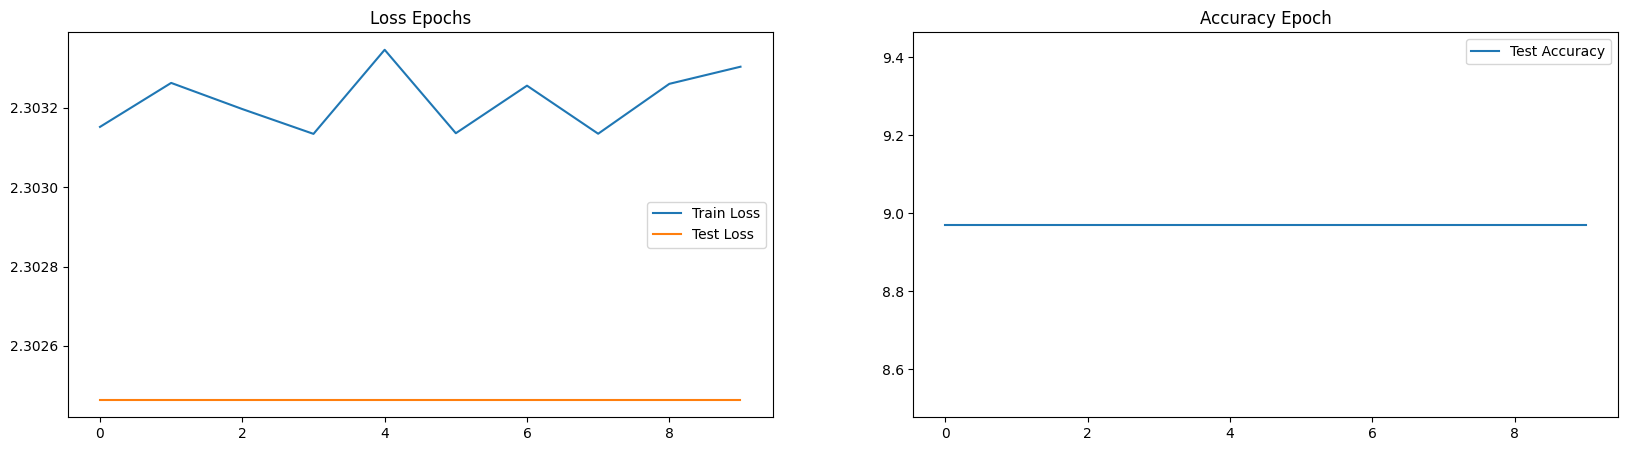

In [10]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [11]:
import torch

def zScoreScaling(tensor):

  mean = torch.mean(tensor)
  std = torch.std(tensor)
  return (tensor - mean) / std

In [12]:
import torch

def minMaxScaling(tensor):
  
  min_val = torch.min(tensor)
  max_val = torch.max(tensor)
  return (tensor - min_val) / (max_val - min_val)

In [13]:
import torch.nn as nn

class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(Linear, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [14]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1.4606, -1.0954, -0.7303],
        [-0.3651,  0.0000,  0.3651],
        [ 0.7303,  1.0954,  1.4606]])
tensor([[0.0000, 0.1250, 0.2500],
        [0.3750, 0.5000, 0.6250],
        [0.7500, 0.8750, 1.0000]])


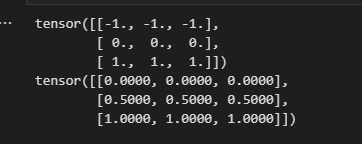

In [16]:
import torch
import torch.nn as nn

class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(Linear, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.linear.weight}")
print(f"Bias = {linear.linear.bias}")

tensor([ 0.1833, -1.2105], grad_fn=<ViewBackward0>)
Weight = Parameter containing:
tensor([[ 0.1260, -0.4282,  0.1852],
        [ 0.3719, -0.1068, -0.4961]], requires_grad=True)
Bias = Parameter containing:
tensor([0.3582, 0.1195], requires_grad=True)
